# Alignment on LJSpeech Dataset

## Inspection

In [1]:
import os
import IPython.display as ipd

import tensorflow as tf

%load_ext autoreload
%autoreload 2

from data_readers.ljspeech_reader import LJSpeechReader  # noqa

# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
gpu_devices

[]

In [ ]:
using_colab = False
if using_colab:
    !wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
    !tar -xf LJSpeech-1.1.tar.bz2 --checkpoint=.5000

In [2]:
ljs_folder = r'G:\datasets\LJSpeech\LJSpeech-1.1\LJSpeech-1.1'
ljsr = LJSpeechReader(ljs_folder)
gen = ljsr.generate_audios()

In [3]:
cur_id, cur_txt, cur_audio, sr = next(gen)
s = LJSpeechReader.serialize(cur_id, cur_txt, cur_audio, sr)
cur_id, cur_txt, cur_audio, sr = LJSpeechReader.deserialize(s)

In [4]:
print(cur_id, cur_txt)
ipd.Audio(cur_audio[:, 0].numpy(), rate=sr.numpy())

tf.Tensor(b'LJ001-0001', shape=(), dtype=string) tf.Tensor(b'printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the exhibition', shape=(), dtype=string)


# Write tfrecords file

In [5]:
ljstfrecords = 'ljspeech.tfrecords'
if not os.path.isfile(ljstfrecords):
    ljsr.write_tfrecords_file(ljstfrecords)

In [6]:
dataset = tf.data.TFRecordDataset(
    'ljspeech.tfrecords'
).map(LJSpeechReader.deserialize)

In [7]:
sample = [x for x in dataset.skip(5).take(1)][0]
cur_id, cur_txt, cur_audio, sr = sample[0], sample[1], sample[2], sample[3]

print(cur_id, cur_txt, sr.numpy())
ipd.Audio(cur_audio[:, 0].numpy(), rate=sr.numpy())

tf.Tensor(b'LJ001-0006', shape=(), dtype=string) tf.Tensor(b'and it is worth mention in passing that, as an example of fine typography,', shape=(), dtype=string) 22050


## Inspect models

In [8]:
from models.alignment_model import PraticantoForcedAligner  # noqa
from models import alignment_losses  # noqa

In [9]:
pfa = PraticantoForcedAligner(vocab=ljsr.tokens, sampling_rate=22050)
alignment_model = pfa.build_models()
alignment_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 waveform (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 char_seq (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 log_mel_spectrogram (Functiona  (None, None, 80)    0           ['waveform[0][0]']               
 l)                                                                                               
                                                                                                  
 char_encoder (Functional)      (None, None, 256)    609360      ['char_seq[0][0]']           

In [10]:
tf.expand_dims(cur_txt, axis=0).shape, tf.expand_dims(cur_audio[:, 0], axis=0).shape

(TensorShape([1]), TensorShape([1, 125341]))

In [11]:
alignment_model([
    tf.expand_dims(tf.strings.bytes_split(cur_txt), axis=0),
    tf.expand_dims(cur_audio[:, 0], axis=0)
]).shape

TensorShape([1, 74, 486])

In [12]:
sample = 'This is my text and it is quite long'
char_input = tf.expand_dims(tf.strings.bytes_split(sample), axis=0)
audio = tf.zeros((1, sr * 2))
out = alignment_model([char_input, audio])
out.shape

TensorShape([1, 36, 169])

In [13]:
t = tf.convert_to_tensor([
    [
        [1, 1, 1,   1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0,   0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0,   1, 1, 1, 0, 0, 0, 0],
        [0, 1, 0,   0, 0, 0, 1, 1, 1, 1],
        [0, 1, 0,   0, 0, 0, 1, 1, 1, 1],
    ],
    [
        [1, 1, 1,   1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0,   0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0,   1, 1, 1, 0, 0, 0, 0],
        [0, 1, 0,   0, 0, 0, 1, 1, 1, 1],
        [0, 1, 0,   0, 0, 0, 1, 1, 1, 1],
    ],
    [
        [1, 1, 1,   1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0,   0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0,   1, 1, 1, 0, 0, 0, 0],
        [0, 1, 0,   0, 0, 0, 1, 1, 1, 1],
        [1, 1, 1,   0, 0, 0, 1, 1, 1, 1],
    ],
])
unpadded_shapes = [
    [4, 10],
    [3, 8],
    [5, 9],
    # [5, 10],
]
alignment_losses.alignment_loss(unpadded_shapes, t)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 5.199999,  2.5     , 10.666666], dtype=float32)>

## Training

In [14]:
def prep_inputs(cur_id, cur_txt, cur_audio, sr):
    cur_txt = tf.ensure_shape(cur_txt, ())
    cur_txt = tf.strings.bytes_split(cur_txt)
    shapes = tf.concat([
        tf.shape(cur_txt),
        1 + (tf.shape(cur_audio[:, 0]) - pfa.frame_length) // pfa.frame_step

        # tf.cast(tf.math.ceil(
        #     (tf.shape(cur_audio[:, 0]) - pfa.frame_length) // pfa.frame_step
        # ) + 1, tf.int32)

    ], axis=0)
    return cur_txt, cur_audio[:, 0], shapes


def prep_batch_inputs(cur_txt, cur_audio, seq_lengths):
    return {
        'char_seq': cur_txt,
        'waveform': cur_audio,
    }, seq_lengths

In [15]:
pad_index = pfa.char_table('[PAD]')
pad_index

<tf.Tensor: shape=(), dtype=int64, numpy=52>

In [16]:
batch_size = 16
dataset = tf.data.TFRecordDataset(
    'ljspeech.tfrecords'
).shuffle(4 * batch_size).repeat().map(LJSpeechReader.deserialize).map(
    prep_inputs
).padded_batch(
    # batch_size, padding_values=(pad_index, 0.0), padded_shapes=(200, 400000)
    batch_size, padding_values=('[PAD]', 0.0, 0), drop_remainder=True
).map(prep_batch_inputs).prefetch(tf.data.AUTOTUNE)

In [17]:
sample = [x for x in dataset.take(1)]
sample[0][0]['char_seq'].shape, sample[0][0]['waveform'].shape, sample[0][1]

(TensorShape([16, 155]),
 TensorShape([16, 213149]),
 <tf.Tensor: shape=(16, 2), dtype=int32, numpy=
 array([[ 86, 462],
        [ 38, 257],
        [116, 756],
        [155, 829],
        [104, 650],
        [ 89, 439],
        [151, 828],
        [ 59, 363],
        [113, 631],
        [112, 604],
        [ 55, 298],
        [113, 571],
        [141, 769],
        [108, 706],
        [151, 777],
        [ 30, 160]])>)

In [18]:
pfa.MelSpectrogram(tf.zeros((219293,))).shape

TensorShape([853, 80])

In [19]:
(1023 * 10 - 1024) / 256

35.9609375

In [20]:
def create_mask(unpadded_shape, padded_shape):
    """ Creates a mask that is 1 in unpadded shape and zero elsewhere
    e.g.
    1 1 1 1 1 1 0 0 0 0
    1 1 1 1 1 1 0 0 0 0
    1 1 1 1 1 1 0 0 0 0
    1 1 1 1 1 1 0 0 0 0
    0 0 0 0 0 0 0 0 0 0
    0 0 0 0 0 0 0 0 0 0
    """
    vec = tf.ones(unpadded_shape)
    pad_shape = tf.stack([
        tf.zeros((2,), dtype=tf.int32),
        padded_shape - unpadded_shape
    ], axis=1)
    vec = tf.pad(vec, pad_shape)
    return vec


s1 = tf.convert_to_tensor([72, 391])
s2 = tf.convert_to_tensor([166, 792])
v1 = tf.ones(s1)

pad_shape = tf.stack([
    tf.zeros((2,), dtype=tf.int32),
    s2-s1
], axis=1)

v2 = tf.pad(v1, pad_shape)

In [21]:
v1.shape, v2.shape

(TensorShape([72, 391]), TensorShape([166, 792]))

In [22]:
tf.stack([
    tf.zeros((2,), dtype=tf.int32),
    s2-s1
], axis=1)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[  0,  94],
       [  0, 401]])>

In [23]:
alignment_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=alignment_losses.alignment_loss
)

In [24]:
os.makedirs('checkpoints', exist_ok=True)
filepath = 'checkpoints/m_{epoch}_{loss:.3f}.chkpt'
chkpt_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor='loss', verbose=1, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch',
)

In [25]:
alignment_model.fit(
    dataset,
    epochs=300,
    steps_per_epoch=len(ljsr.df_audios) // batch_size,
    callbacks=[chkpt_callback]
)

Epoch 1/300
272/818 [========>.....................] - ETA: 32:18 - loss: 119.3910


KeyboardInterrupt



# Visual evaluation of results

In [26]:
from matplotlib import pyplot as plt
%matplotlib inline

In [27]:
# alignment_model.load_weights('checkpoints/m_1_33.717620849609375.chkpt')

In [28]:
samples = [x for x in dataset.take(1)]

In [29]:
preds = alignment_model(samples[0][0])
preds.shape, samples[0][1].shape

(TensorShape([16, 168, 853]), TensorShape([16, 2]))

tf.Tensor([ 99 673], shape=(2,), dtype=int32)


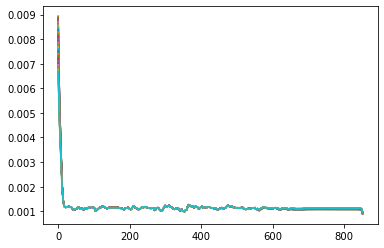

In [31]:
idx = 2
unpadded_lens = samples[0][1][idx]
print(unpadded_lens)
for k in range(30):
    plt.plot(preds[idx, k].numpy())